In [97]:
import pandas as pd

data = pd.read_csv('data.csv', sep=';', encoding='latin1')

In [98]:
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
nltk.download('rslp')

stop_words = set(stopwords.words('portuguese'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Zá-úÁ-ÚçÇ\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['text'] = data['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rodrigopierre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /home/rodrigopierre/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [99]:
from sklearn.model_selection import train_test_split

X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [100]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)


In [101]:
# Salvar o vocabulário do conjunto de treinamento
with open('vocabulary.txt', 'w') as f:
    for word, index in tokenizer.word_index.items():
        f.write(f"{word}:{index}\n")


In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/home/rodrigopierre/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [103]:
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.5575 - loss: 0.6896 - val_accuracy: 0.3882 - val_loss: 0.7049
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5972 - loss: 0.6639 - val_accuracy: 0.6824 - val_loss: 0.6739
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7874 - loss: 0.6272 - val_accuracy: 0.7412 - val_loss: 0.6106
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9089 - loss: 0.5188 - val_accuracy: 0.8471 - val_loss: 0.4554
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.9674 - loss: 0.3390 - val_accuracy: 0.6824 - val_loss: 0.6109
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.9198 - loss: 0.1929 - val_accuracy: 0.8471 - val_loss: 0.3078
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9819 - loss: 0.0919 - val_accuracy: 0.8588 - val_loss: 0.2725
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9885 - loss: 0.0692 - val_accuracy: 0

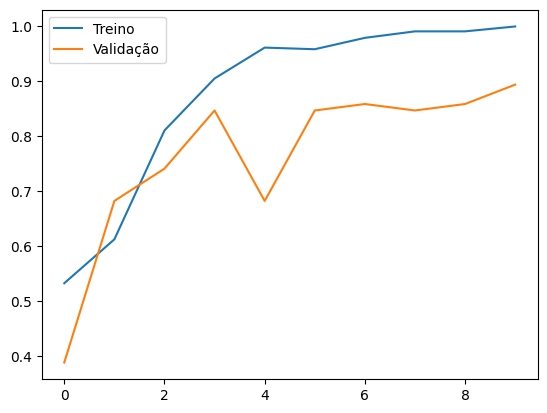

In [104]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.legend()
plt.show()


In [105]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8963 - loss: 0.2389
Acurácia no conjunto de teste: 89.41%


In [106]:
model.save('model.h5')

In [107]:
# Exemplos para teste

new_comments = ["O serviço é muito bom e o pessoal é muito atencioso.", "Achei muito top o celular!"]
new_comments_seq = tokenizer.texts_to_sequences(new_comments)
new_comments_pad = pad_sequences(new_comments_seq, maxlen=100)

predictions = model.predict(new_comments_pad)
print(['Positivo' if p > 0.5 else 'Negativo' for p in predictions])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
['Positivo', 'Positivo']
